# Example: Add scalars

In [4]:
import numpy as np

import numba
from numba import cuda

@cuda.jit
def add_scalars(a, b, c):
    c[0] = a + b

In [5]:
dev_c = cuda.device_array((1,), np.float32)

add_scalars[1, 1](2.0, 7.0, dev_c)

c = dev_c.copy_to_host()
print(f"2.0 + 7.0 = {c[0]}")

2.0 + 7.0 = 9.0


/home/arnis/miniconda3/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


# Example: Add arrays

In [6]:
@cuda.jit
def add_array(a, b, c):
    i = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if i < a.size:
        c[i] = a[i] + b[i]

In [7]:
N = 20
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)
dev_c = cuda.device_array_like(a)

add_array[4, 8](a, b, dev_c)

c = dev_c.copy_to_host()
print(c)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38.]


/home/arnis/miniconda3/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/arnis/miniconda3/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


# Example: Add arrays with cuda.grid

In [8]:
@cuda.jit
def add_array(a, b, c):
    i = cuda.grid(1)
    if i < a.size:
        c[i] = a[i] + b[i]

In [10]:
dev_a = cuda.to_device(a)
dev_b = cuda.to_device(b)

add_array[4, 8](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
print(c)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38.]


A "reasonable" number of threads for modern GPUs is 256.

In [11]:
N = 1_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = cuda.to_device(a)
dev_b = cuda.to_device(b)
dev_c = cuda.device_array_like(a)

threads_per_block = 256
blocks_per_grid = (N + (threads_per_block - 1)) // threads_per_block
# Note that
#     blocks_per_grid == ceil(N / threads_per_block)
# ensures that blocks_per_grid * threads_per_block >= N

add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
np.allclose(a + b, c)

True

# Grid-stride loops

In cases where the number of blocks per grid exceeds the hardware limit but the array fits in memory, instead of using one thread per array element, we can use one thread to process several elements. We will do so by using a technique called *grid-stride loops*. Besides overcoming hardware limitations, grid-stride loop kernels benefit from reusing threads, by minimizing thread creation/destruction overhead.

## Example: Add arrays with grid striding

In [13]:
@cuda.jit
def add_array_gs(a, b, c):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    for i in range(i_start, a.size, threads_per_grid):
        c[i] = a[i] + b[i]

In [14]:
threads_per_block = 256
blocks_per_grid_gs = 32 * 80  # Use 32 * multiple of streaming multiprocessors
# 32 * 80 * 256 < 1_000_000 so one thread will process more than one array element

add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
c = dev_c.copy_to_host()
np.allclose(a + b, c)

True

# A 2D Example

To end this tutorial, let's craft a 2D kernel to apply [logarithmic correction](https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.adjust_log) to an image.

Given an image $I(x, y)$ with values between 0 and 1, the log-corrected image is given by

$$I_c(x, y) = \gamma \log_2 (1 + I(x, y))$$

In [15]:
from skimage import data

moon = data.moon().astype(np.float32) / 255.

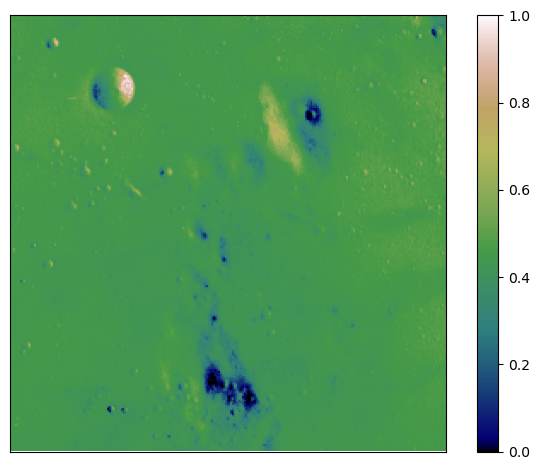

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(moon, cmap="gist_earth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(im)
fig.tight_layout()

Let's write the kernel.

In [17]:
import math

# Example 1.5: 2D kernel
@cuda.jit
def adjust_log(inp, gain, out):
    ix, iy = cuda.grid(2) # The first index is the fastest dimension
    threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #  threads per grid dimension
    
    n0, n1 = inp.shape # The last index is the fastest dimension
    # Stride each dimension independently
    for i0 in range(iy, n0, threads_per_grid_y):
        for i1 in range(ix, n1, threads_per_grid_x):
            out[i0, i1] = gain * math.log2(1 + inp[i0, i1])

In [18]:
threads_per_block_2d = (16, 16)  #  256 threads total
blocks_per_grid_2d = (64, 64)

In [19]:
moon_gpu = cuda.to_device(moon)
moon_corr_gpu = cuda.device_array_like(moon_gpu)

adjust_log[blocks_per_grid_2d, threads_per_block_2d](moon_gpu, 1.0, moon_corr_gpu)
moon_corr = moon_corr_gpu.copy_to_host()

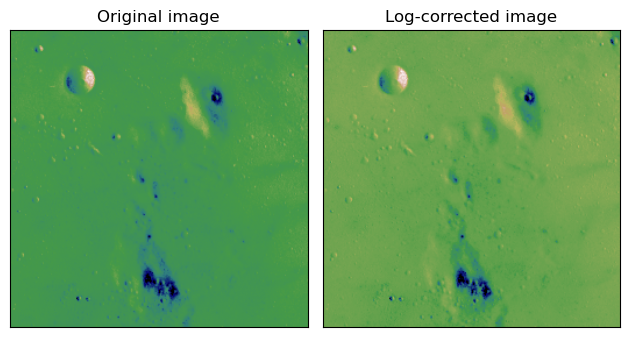

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(moon, cmap="gist_earth")
ax2.imshow(moon_corr, cmap="gist_earth")
ax1.set(title="Original image")
ax2.set(title="Log-corrected image")
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()